### Импорт библиотек

In [1]:
import gc

import os
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, auc

from xgboost import XGBClassifier

from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

### Утилиты

Из-за ограниченности вычислительных ресурсов (обработка и агрегация 270 млн транзакций) будем использовать функции-утилиты от организаторов соревнования.

`read_parquet_dataset_from_local` - Функция для чтения parquet партиций и преобразования данных в Pandas DataFrame

In [2]:
def read_parquet_dataset_from_local(
    path_to_dataset,
    start_from=0,
    num_parts_to_read=2,
    columns=None,
    verbose=False):
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame
    и возвращает
    """

    result = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm(chunks, desc='Reading dataset with pandas'):
        chunk = pd.read_parquet(chunk_path, columns=columns)
        result.append(chunk)

    return pd.concat(result).reset_index(drop=True)

Разграничим категориальные, числовые и вещественные признаки для их дальнейшей обработки

In [3]:
numeric_features = ['days_before', 'hour_diff']

float_features = ['amnt']

categorical_features = [
    'currency', 'operation_kind', 'card_type',
    'operation_type', 'operation_type_group', 'ecommerce_flag',
    'payment_system', 'income_flag', 'mcc', 'country', 'city',
    'mcc_category', 'day_of_week', 'hour', 'weekofyear'
]

Т.к мы не можем напрямую использовать сырые последовательности транзакций (только в RNN/LSTM/GRU) для предсказаний, мы будем использовать агрегированные данные по каждому клиенту за 12 мес. В результате использования нижеописанных функций в итоге мы получим из датасета $\{num_{transactions}\times19\}$ датасет для обучения размером $\{num_{clients}\times num_{genaggfeatures}\}$

In [4]:
def __amnt_pivot_table_by_column(data, column, agg_funcs=None):
    """
    Строит pivot table для между колонкой `amnt`  и column на основе
    переданных aggregations
    """

    if agg_funcs is None:
        agg_funcs = ['mean', 'count', 'median', 'std']

    aggregates = pd.pivot_table(
        data,
        values='amnt',
        index=['app_id'],
        columns=[column],
        aggfunc={'amnt': agg_funcs},
        fill_value=0.0
    )

    aggregates.columns = [
        f'{col[0]}_{column}_{col[1]}' for col in aggregates.columns.values
    ]

    return aggregates


def extract_basic_aggregations(transactions_frame, cat_columns=None, agg_funcs=None):

    if not cat_columns:
        cat_columns = categorical_features

    pivot_tables = []

    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column(
            transactions_frame,
            column=col,
            agg_funcs=agg_funcs
        ))

    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        'amnt': ['min', 'max', 'mean', 'median', 'sum', 'std'],
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        'days_before': ['min', 'max', 'median']}

    numeric_stats = transactions_frame.groupby(['app_id']).agg(aggs)

    numeric_stats.columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()


def prepare_transactions_dataset(
    path_to_dataset,
    num_parts_to_preprocess_at_once=1,
    num_parts_total=50,
    save_to_path=None,
    verbose=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить
    модель для целевой задачи
    """

    preprocessed_frames = []
    block = 0

    for step in tqdm(
        range(0, num_parts_total, num_parts_to_preprocess_at_once),
        desc='Transforming transactions data'
    ):
        transactions_frame = read_parquet_dataset_from_local(
            path_to_dataset,
            step,
            num_parts_to_preprocess_at_once,
            verbose=verbose
        )

        features = extract_basic_aggregations(
            transactions_frame,
            cat_columns=[
                'mcc_category',
                'day_of_week',
                'operation_type',
                'operation_type_group',
                'country',
                'currency',
                'operation_kind',
                'ecommerce_flag'
            ])

        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(
                save_to_path,
                f'processed_chunk_{block_as_str}.parquet'
            ))

        preprocessed_frames.append(features)

    return pd.concat(preprocessed_frames)

### Процессинг

In [5]:
!rm -rf preprocessed_transactions
!mkdir preprocessed_transactions

Обработаем все .pq партиции и создадим датасет с агрегированными клиентскими данными. Агрегации вида: min, max, mean, median, std, var, nunique

In [6]:
data = prepare_transactions_dataset(
    'train_transactions',
    num_parts_to_preprocess_at_once=10,
    num_parts_total=50,
    save_to_path='preprocessed_transactions'
)

Transforming transactions data:   0%|          | 0/5 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
print(f'Объем в RAM обработанных данных: {round(data.memory_usage(index=True).sum() / 10**9, 3)} Gb')

Объем в RAM обработанных данных: 3.385 Gb


In [8]:
gc.collect()

0

In [9]:
train_targets = pd.read_csv('train_target.csv')
train_targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [10]:
train_dataset = data.merge(train_targets, on='app_id')
train_dataset.head()

,app_id,count_mcc_category_1,count_mcc_category_2,count_mcc_category_3,count_mcc_category_4,count_mcc_category_5,count_mcc_category_6,count_mcc_category_7,count_mcc_category_8,count_mcc_category_9,count_mcc_category_10,count_mcc_category_11,count_mcc_category_12,count_mcc_category_13,count_mcc_category_14,count_mcc_category_15,count_mcc_category_16,count_mcc_category_17,count_mcc_category_18,count_mcc_category_19,count_mcc_category_20,count_mcc_category_21,count_mcc_category_22,count_mcc_category_23,count_mcc_category_24,count_mcc_category_25,count_mcc_category_26,count_mcc_category_27,count_mcc_category_28,mean_mcc_category_1,mean_mcc_category_2,mean_mcc_category_3,mean_mcc_category_4,mean_mcc_category_5,mean_mcc_category_6,mean_mcc_category_7,mean_mcc_category_8,mean_mcc_category_9,mean_mcc_category_10,mean_mcc_category_11,mean_mcc_category_12,mean_mcc_category_13,mean_mcc_category_14,mean_mcc_category_15,mean_mcc_category_16,mean_mcc_category_17,mean_mcc_category_18,mean_mcc_category_19,mean_mcc_category_20,mean_mcc_category_21,mean_mcc_category_22,mean_mcc_category_23,mean_mcc_category_24,mean_mcc_category_25,mean_mcc_category_26,mean_mcc_category_27,mean_mcc_category_28,median_mcc_category_1,median_mcc_category_2,median_mcc_category_3,median_mcc_category_4,median_mcc_category_5,median_mcc_category_6,median_mcc_category_7,median_mcc_category_8,median_mcc_category_9,median_mcc_category_10,median_mcc_category_11,median_mcc_category_12,median_mcc_category_13,median_mcc_category_14,median_mcc_category_15,median_mcc_category_16,median_mcc_category_17,median_mcc_category_18,median_mcc_category_19,median_mcc_category_20,median_mcc_category_21,median_mcc_category_22,median_mcc_category_23,median_mcc_category_24,median_mcc_category_25,median_mcc_category_26,median_mcc_category_27,median_mcc_category_28,std_mcc_category_1,std_mcc_category_2,std_mcc_category_3,std_mcc_category_4,std_mcc_category_5,std_mcc_category_6,std_mcc_category_7,std_mcc_category_8,std_mcc_category_9,std_mcc_category_10,std_mcc_category_11,std_mcc_category_12,std_mcc_category_13,std_mcc_category_14,std_mcc_category_15,std_mcc_category_16,std_mcc_category_17,std_mcc_category_18,std_mcc_category_19,std_mcc_category_20,std_mcc_category_21,std_mcc_category_22,std_mcc_category_23,std_mcc_category_24,std_mcc_category_25,std_mcc_category_26,std_mcc_category_27,std_mcc_category_28,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7,mean_day_of_week_1,mean_day_of_week_2,mean_day_of_week_3,mean_day_of_week_4,mean_day_of_week_5,mean_day_of_week_6,mean_day_of_week_7,median_day_of_week_1,median_day_of_week_2,median_day_of_week_3,median_day_of_week_4,median_day_of_week_5,median_day_of_week_6,median_day_of_week_7,std_day_of_week_1,std_day_of_week_2,std_day_of_week_3,std_day_of_week_4,std_day_of_week_5,std_day_of_week_6,std_day_of_week_7,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_12,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_18,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,mean_operation_type_1,mean_operation_type_2,mean_operation_type_3,mean_operation_type_4,mean_operation_type_5,mean_operation_type_6,mean_operation_type_7,mean_operation_type_8,mean_operation_type_9,mean_operation_type_10,mean_operation_type_11,mean_operation_type_12,mean_operation_type_13,mean_operation_type_14,mean_operation_type_15,mean_operation_type_16,mean_operation_type_17,mean_operation_type_18,mean_operation_type_19,mean_operation_type_20,mean_operation_type_21,mean_operation_type_22,median_operation_type_1,median_operation_type_2,median_ope

Итоговый датасет для обучения модели: (963811, 441) - <b>438</b> аггрегированных фичей

In [ ]:
train_dataset.to_parquet(
    'features_data.parquet.gzip',
    index=False,
    compression='gzip')

Функция-утилита для построения и визуализации ROC-кривой

In [12]:
def plot_roc_curve(title, fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(12, 8))

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr,
                tpr,
                lw=1,
                alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)
        )

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Constant Random Model', alpha=.8)

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8
    )

    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.fill_between(
        mean_fpr, tprs_lower, tprs_upper,
        color='grey', alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {title} model')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)


def compute_roc_auc(clf, section):
    y_predict = clf.predict_proba(section[features])[:, 1]
    fpr, tpr, thresholds = roc_curve(section.flag.values, y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

### Построение Baseline моделей кредитного скоринга

#### Логистическая регрессия

Training with fold 1 started.
Val ROC-AUC: 0.7489394754946994
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.7552702222341823
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.7418971883132888
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.7395390639890929
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.738625164478772
Training with fold 5 completed.


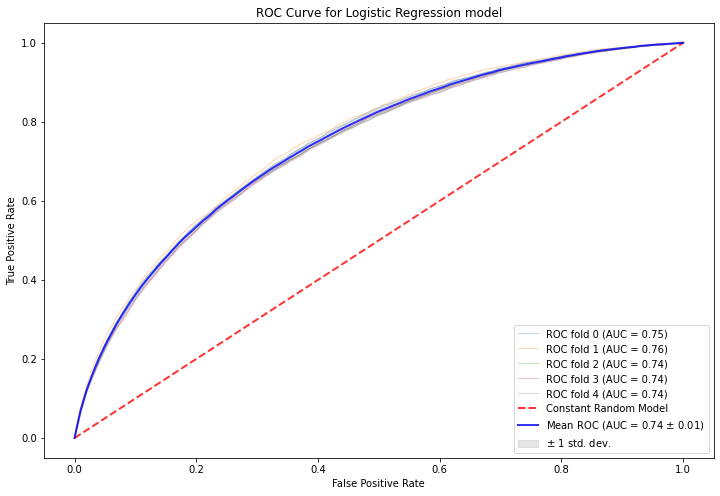

CPU times: user 12min 49s, sys: 4min 46s, total: 17min 35s
Wall time: 4min 13s


,AUC Train,AUC Test
0,0.748648,0.748939
1,0.747126,0.755270
2,0.750398,0.741897
3,0.751043,0.739539
4,0.750948,0.738625


In [13]:
%%time

targets = train_dataset.flag.values
features = [x for x in train_dataset.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

logreg_clf = make_pipeline(StandardScaler(), LogisticRegression(
    random_state=41,
    class_weight='balanced',
    C=0.1,
    penalty='l2'
))

for fold_, (train_idx, val_idx) in enumerate(cv.split(train_dataset, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = train_dataset.iloc[train_idx], train_dataset.iloc[val_idx]

    logreg_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train = compute_roc_auc(logreg_clf, train)
    fpr, tpr, auc_score = compute_roc_auc(logreg_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Logistic Regression', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

#### Случайный лес

Training with fold 1 started.
Val ROC-AUC: 0.7470649762356905
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.7535698080622962
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.7385701413769585
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.7411064775056064
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.7410318390407247
Training with fold 5 completed.


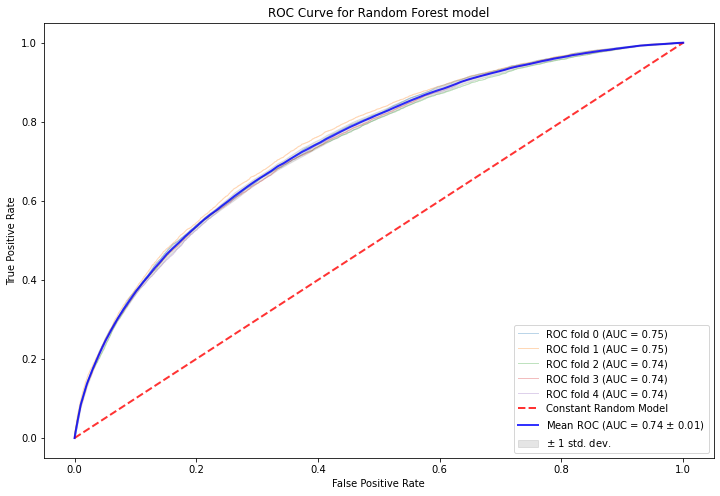

CPU times: user 9h 56min 10s, sys: 40.5 s, total: 9h 56min 50s
Wall time: 1h 26min 34s


,AUC Train,AUC Test
0,0.829560,0.747065
1,0.828455,0.753570
2,0.830620,0.738570
3,0.830113,0.741106
4,0.830652,0.741032


In [14]:
%%time

targets = train_dataset.flag.values
features = [x for x in train_dataset.columns if x not in ['app_id', 'flag']]

rf_params = {
    'class_weight': 'balanced',
    'n_estimators': 1000,
    'random_state': 41,
    'bootstrap': True,
    'oob_score': False,
    'max_depth': 10,
    'n_jobs': 7
}

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

rf_clf = RandomForestClassifier(**rf_params)

for fold_, (train_idx, val_idx) in enumerate(cv.split(train_dataset, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = train_dataset.iloc[train_idx], train_dataset.iloc[val_idx]

    rf_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train = compute_roc_auc(rf_clf, train)
    fpr, tpr, auc_score = compute_roc_auc(rf_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Random Forest', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

#### Градиентный бустинг

Training with fold 1 started.
[17:02:17] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Val ROC-AUC: 0.7823874503128676
Training with fold 1 completed.
Training with fold 2 started.
[17:52:05] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Val ROC-AUC: 0.7897731654079193
Training with fold 2 completed.
Training with fold 3 started.
[18:41:20] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bi

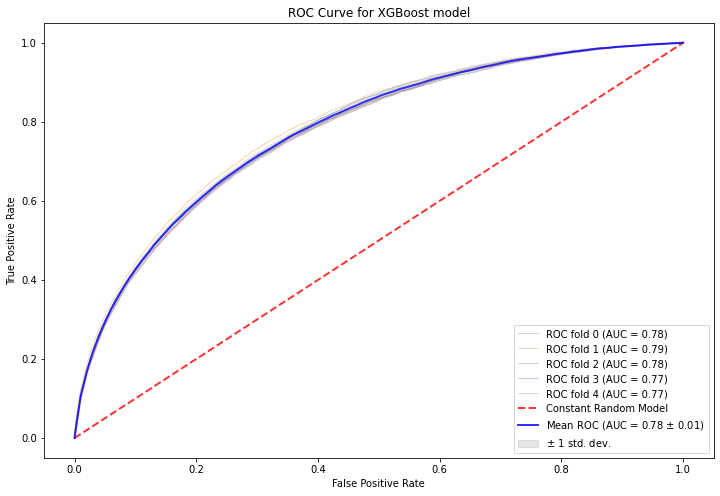

CPU times: user 1d 4h 12min 38s, sys: 1min 2s, total: 1d 4h 13min 40s
Wall time: 4h 6min 42s


,AUC Train,AUC Test
0,0.881053,0.782387
1,0.882556,0.789773
2,0.883923,0.777851
3,0.884271,0.774802
4,0.884989,0.774259


In [15]:
%%time

targets = train_dataset.flag.values
features = [x for x in train_dataset.columns if x not in ['app_id', 'flag']]


xgb_params = {
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'random_state': 41,
    'scale_pos_weight': 4,
    'learning_rate': 0.05,
    'max_depth': 5,
    'booster': 'gbtree',
    'n_jobs': 7
}

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

xgb_clf = XGBClassifier(**xgb_params)

for fold_, (train_idx, val_idx) in enumerate(cv.split(train_dataset, targets), 1):
    print(f'Training with fold {fold_} started.')
    
    train, val = train_dataset.iloc[train_idx], train_dataset.iloc[val_idx]

    xgb_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train = compute_roc_auc(xgb_clf, train)
    fpr, tpr, auc_score = compute_roc_auc(xgb_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('XGBoost', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

#### Итого:
- наиболее быстрая (как в обучении, так и в инференсе) модель - линейная с Mean ROC-AUC = 0.745; довольно приемлемый результат
- лучшая baseline модель без подгонки гиперпараметров через GridSearch (или hyperopt) - Градиентный Бустинг: XGBoost (а также в теории CatBoost/LGBM) с Mean ROC-AUC = 0.78

#### В дальнейшем:
Для построения демо-стенда и презентации модель будет улучшаться с подбором гиперпараметров, feature engineering, выделением важных признаков, возможным блендингом с LGBM/Catboost с весами, и т.д